# Gene Scores

This time at a single cell level.

In [66]:
library(SnapATAC)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)
library(scales)
library(edgeR)

In [2]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [3]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [4]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200217_trajectory/sessions/20200223_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

,sample,umap.1,umap.2,cluster,dpt_pseudotime,barcode
,<fct>,<dbl>,<dbl>,<int>,<dbl>,<list>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,0.00000000,AAACAACGACGATTAC
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,0.03794836,AAACAACGACTCACGG


In [5]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [6]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [7]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [8]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [9]:
# Note that the peaks matrix is not binarized

In [10]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

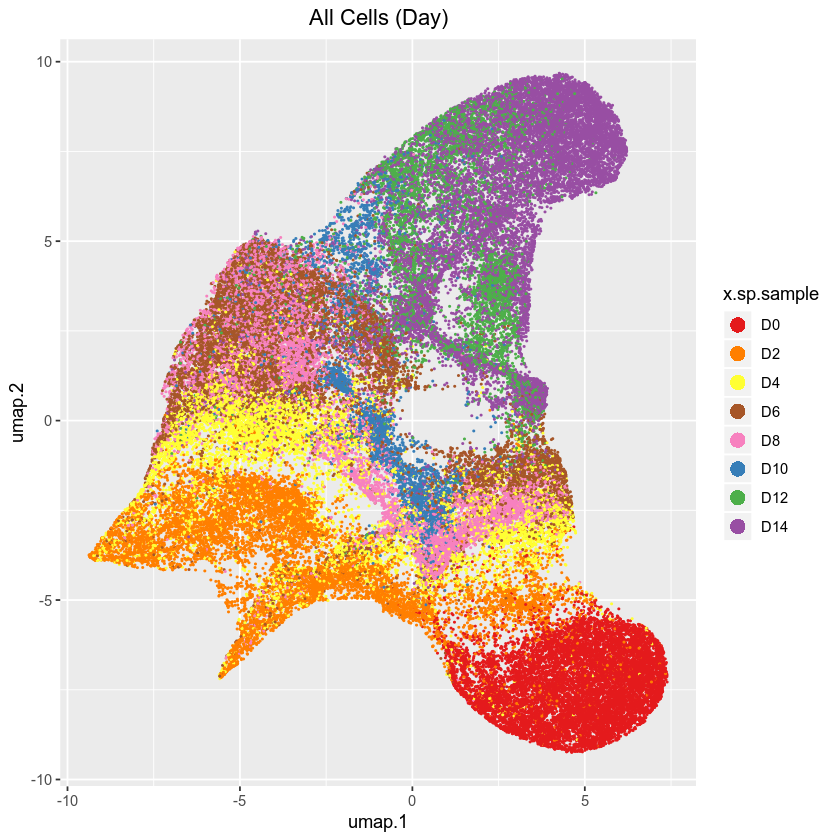

In [11]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

## Gene Annotations

In [12]:
library(EnsDb.Hsapiens.v86)

Loading required package: ensembldb

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter




In [13]:
edb <- EnsDb.Hsapiens.v86

In [14]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [15]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 0)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 1 out-of-bound range located on sequence MT.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information."


In [16]:
head(prom.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames        ranges strand |   gene_name         gene_id
                     <Rle>     <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1   67091-69090      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1 180393-182392      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [17]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames    ranges strand |   gene_name         gene_id
                     <Rle> <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1     69091      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1    182393      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

## Make Gene x Cluster matrix

### Promoters Only

In [20]:
intervals_gr = GRanges(sub("chr", "", as.character(x.sp@peak)))

In [23]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 26514 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2           4
      [2]         2           5
      [3]         6          59
      [4]         6          60
      [5]         7          80
      ...       ...         ...
  [26510]     22252      467091
  [26511]     22255      467113
  [26512]     22261      467310
  [26513]     22262      467324
  [26514]     22262      467325
  -------
  queryLength: 22285 / subjectLength: 467339

In [27]:
# sparse matrix to multiply with
agg_matrix = sparseMatrix(i=subjectHits(overlaps),
                          j=queryHits(overlaps),
                          x=1L,
                          dims=c(subjectLength(overlaps), queryLength(overlaps)))

In [44]:
summed_gene = x.sp@pmat %*% agg_matrix

In [45]:
summed_gene = as.matrix(t(summed_gene))
head(summed_gene)

AAACAACGACGATTAC,AAACAACGACTCACGG,AAACAACGAGCGCACT,AAACAACGATGGAACG,AAACACGCTACGCCAC,AAACACGCTAGACTTC,AAACACGCTAGGTAAT,AAACACGCTAGTACGG,AAACACGCTCCTAGCG,AAACACGCTCCTCAAA,⋯,TTTGGGAACAGGTCCC,TTTGGGAACATAACCC,TTTGGGAACATCCGTA,TTTGGGAACCCCGCAA,TTTGGGAACGCTGGCT,TTTGGGAACTAAGTAG,TTTGGGAACTCGTAAC,TTTGGGATGACTAGTC,TTTGGGATGTAATAGG,TTTGGGATGTAGCAGG
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0


In [48]:
# remove genes with duplicate entries
summed_gene = summed_gene[!duplicated(prom.hg38$gene_name) ,]
rownames(summed_gene) = prom.hg38$gene_name[!duplicated(prom.hg38$gene_name)]

In [50]:
# DESeq2 normalize
summed_gene = as.data.frame(t(t(summed_gene)/colSums(summed_gene)))

head(summed_gene)

,AAACAACGACGATTAC,AAACAACGACTCACGG,AAACAACGAGCGCACT,AAACAACGATGGAACG,AAACACGCTACGCCAC,AAACACGCTAGACTTC,AAACACGCTAGGTAAT,AAACACGCTAGTACGG,AAACACGCTCCTAGCG,AAACACGCTCCTCAAA,⋯,TTTGGGAACAGGTCCC,TTTGGGAACATAACCC,TTTGGGAACATCCGTA,TTTGGGAACCCCGCAA,TTTGGGAACGCTGGCT,TTTGGGAACTAAGTAG,TTTGGGAACTCGTAAC,TTTGGGATGACTAGTC,TTTGGGATGTAATAGG,TTTGGGATGTAGCAGG
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OR4F5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0000000000,0.0000000000,0,0,0
FO538757.2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0001689475,0.0000000000,0,0,0
FO538757.1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0000000000,0.0000000000,0,0,0
OR4F29,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0000000000,0.0000000000,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0000000000,0.0000000000,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0.0000000000,0.0001786352,0,0,0


In [76]:
rownames(summed_gene)[grep("NAN", rownames(summed_gene))]

[1] "NANOS1"  "NANOGNB" "NANOG"   "NANOGP8" "NANOS3"  "NANOS2"  "NANP"   
[8] "NANS"

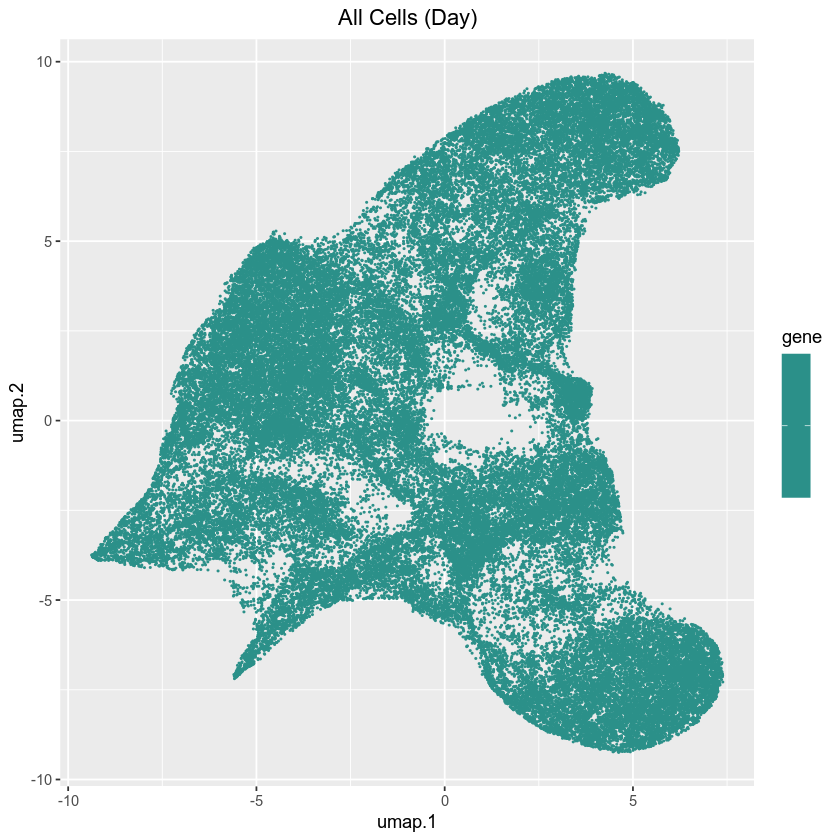

In [109]:
options(repr.plot.width = 7, repr.plot.height = 7)

cur_gene = log2(1+ as.numeric(summed_gene["POU1F1",]))
df = data.frame(x.sp@umap, x.sp@sample, gene=cur_gene)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=gene)) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
scale_color_viridis_c(limits=c(0,quantile(cur_gene, 1)), oob=squish) +
theme(plot.title = element_text(hjust = 0.5)) 
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

### Inverse Distance Model

In [ ]:
distal_overlaps = findOverlaps(tss.hg38+1000000, intervals_gr)
distal_overlaps

In [82]:
gene_peak_coeff = 1000*(1+abs(mid(intervals_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

In [88]:
# sparse matrix to multiply with
distal_agg_matrix = sparseMatrix(i=subjectHits(distal_overlaps),
                          j=queryHits(distal_overlaps),
                          x=gene_peak_coeff,
                          dims=c(subjectLength(distal_overlaps), queryLength(distal_overlaps)))

In [89]:
distal_summed_gene = x.sp@pmat %*% distal_agg_matrix

In [90]:
distal_summed_gene = as.matrix(t(distal_summed_gene))
head(distal_summed_gene)

AAACAACGACGATTAC,AAACAACGACTCACGG,AAACAACGAGCGCACT,AAACAACGATGGAACG,AAACACGCTACGCCAC,AAACACGCTAGACTTC,AAACACGCTAGGTAAT,AAACACGCTAGTACGG,AAACACGCTCCTAGCG,AAACACGCTCCTCAAA,⋯,TTTGGGAACAGGTCCC,TTTGGGAACATAACCC,TTTGGGAACATCCGTA,TTTGGGAACCCCGCAA,TTTGGGAACGCTGGCT,TTTGGGAACTAAGTAG,TTTGGGAACTCGTAAC,TTTGGGATGACTAGTC,TTTGGGATGTAATAGG,TTTGGGATGTAGCAGG
0.6186667,0.1390799,0.1326749,0.2813095,0.2750278,0.4797751,0.09409537,0.5594657,0.1306107,0.00000000,⋯,0.3332299,0.3451996,1.062533,0.9247414,0.2778642,0.5654136,0.6789342,0.629578,0.7082524,0.4701972
1.0798421,0.1533440,0.1452920,0.3771535,0.3028691,0.5283365,0.17811228,0.7515344,0.2113114,0.00000000,⋯,0.6989181,0.4461545,1.260430,1.0757986,0.3727362,8.5973081,1.0870612,1.093619,0.9816650,0.5842742
1.0967646,0.1559386,0.1475646,0.3834829,0.3079287,0.5371689,0.18224529,0.7640004,0.2144734,0.00000000,⋯,0.7670705,0.4534199,1.286584,1.0923897,0.3788718,1.4578952,1.1071741,1.111163,0.9985921,0.5935815
2.2407956,0.2086028,0.8001091,0.8728521,0.7514666,2.0899172,0.37180455,1.2248091,0.2755001,0.06881508,⋯,1.0671445,1.2287787,2.694188,2.1738184,1.0008707,1.2167671,2.4744827,2.001799,2.1103013,1.5337273
3.6125391,0.3969277,1.3824753,1.3599287,1.2938843,3.3365692,0.78011536,2.0857306,0.3950845,0.08544570,⋯,1.4147533,1.9213566,5.133815,3.2289186,1.4314888,2.1913260,4.3900119,3.567679,3.5993580,2.4836322
7.2126404,2.4246425,2.3532192,3.1531087,3.3552810,13.7440804,0.61090410,7.3002197,0.8877756,0.11754022,⋯,3.1105496,6.3414654,8.928451,8.9801205,2.8713630,4.5729151,18.1374026,24.380793,12.1412839,9.7569781


In [91]:
# remove genes with duplicate entries
distal_summed_gene = distal_summed_gene[!duplicated(prom.hg38$gene_name) ,]
rownames(distal_summed_gene) = prom.hg38$gene_name[!duplicated(prom.hg38$gene_name)]

In [ ]:
# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/calcNormFactors(distal_summed_gene)))

head(distal_summed_gene)

In [102]:
rownames(distal_summed_gene)[grep("POU5", rownames(distal_summed_gene))]

[1] "POU5F2"  "POU5F1"  "POU5F1B"

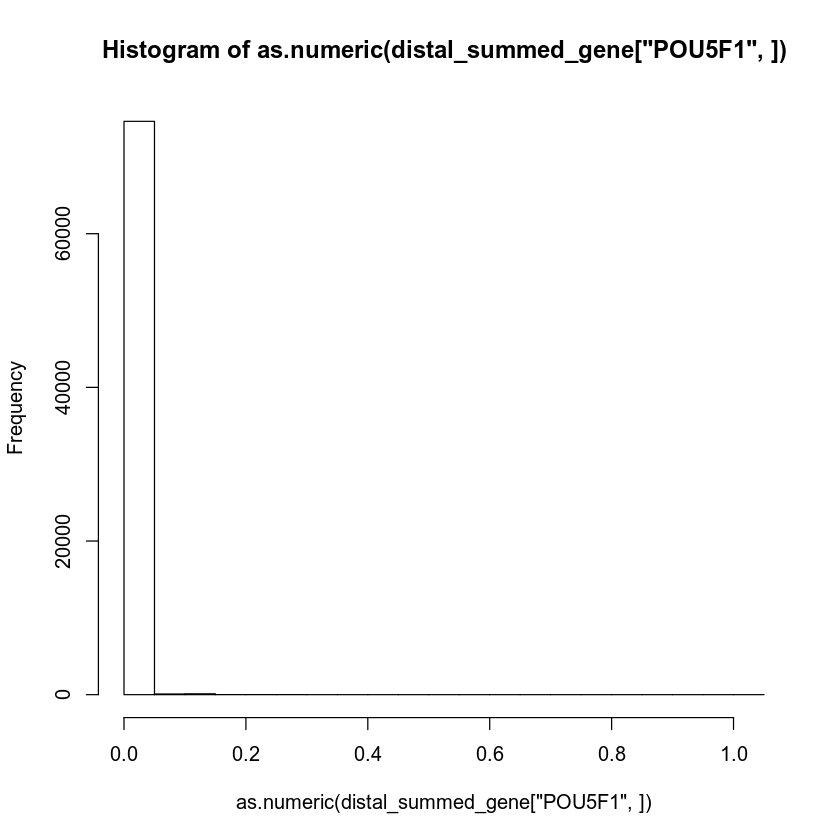

In [103]:
hist(as.numeric(distal_summed_gene["POU5F1",]))

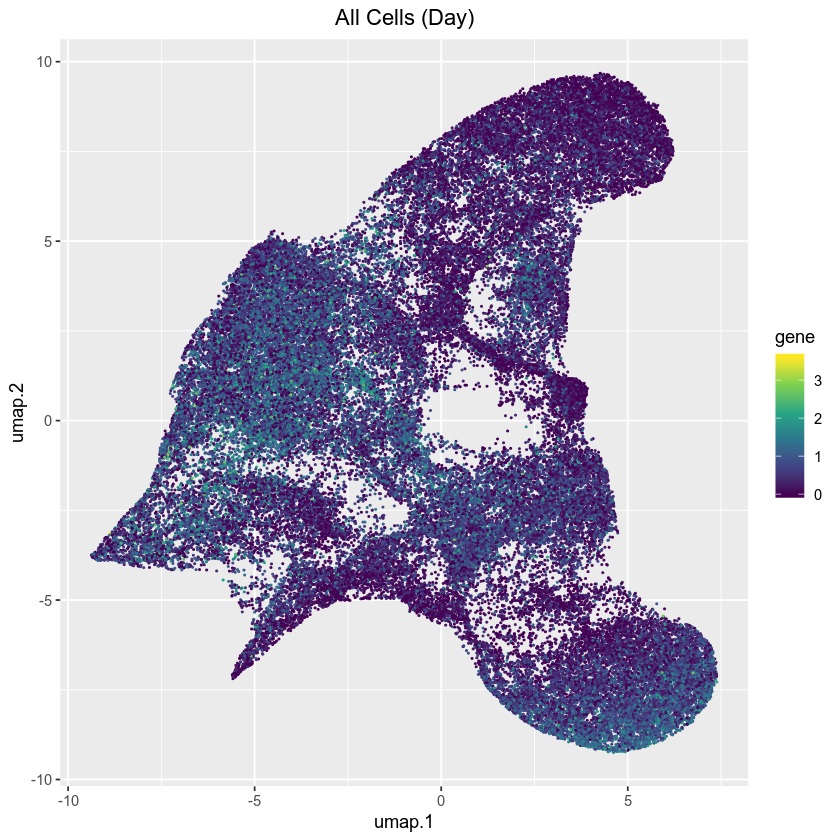

In [107]:
options(repr.plot.width = 7, repr.plot.height = 7)

cur_gene = log2(1+as.numeric(distal_summed_gene["POU1F1",]))
df = data.frame(x.sp@umap, x.sp@sample, gene=cur_gene)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=gene)) +
# scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
scale_color_viridis_c(limits=c(0,quantile(cur_gene, 1)), oob=squish) +
theme(plot.title = element_text(hjust = 0.5)) 
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))